In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-up0y85nw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-up0y85nw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=7cd6d52fb4e0d5c0fd84764dfc9a93208c9b104a5f38580a270240288fda73b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-9zkxov9c/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [ ]:
!pip install -q supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Change to the home directory (optional in Colab, as it starts in /content)
import os
os.chdir('/content')

# Create a weights directory
!mkdir weights

# Change to the weights directory
os.chdir('weights')

# Download the weights file
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [ ]:
import os

# Define the checkpoint path
CHECKPOINT_PATH = os.path.join('/content', 'weights', 'sam_vit_h_4b8939.pth')

# Check if the checkpoint file exists
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "chair.jpeg"
IMAGE_PATH = "/content/chair.jpg"

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
import numpy as np

# Assuming sam_result contains multiple detections and you want to assign a single class ID for all
num_detections = len(sam_result)
class_ids = np.zeros(num_detections)  # Assign class ID 0 to all detections

# Create the detections object with dummy class IDs
detections = sv.Detections.from_sam(sam_result=sam_result)
detections.class_id = class_ids  # Assign the dummy class IDs
# Example: Assigning class IDs based on specific logic (adjust as necessary)
class_ids = np.random.randint(0, 3, size=num_detections)  # Randomly assigning class IDs 0, 1, or 2
detections.class_id = class_ids


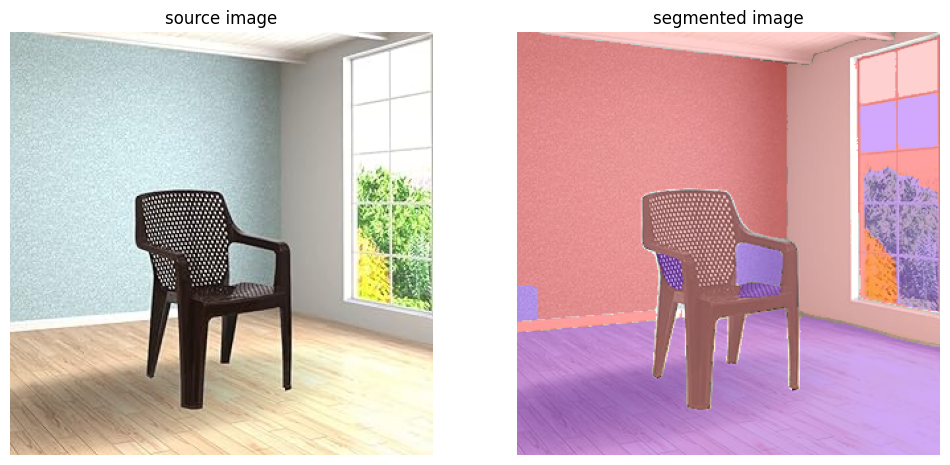

In [ ]:
mask_annotator = sv.MaskAnnotator()

# Annotate the image
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Plot the images
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


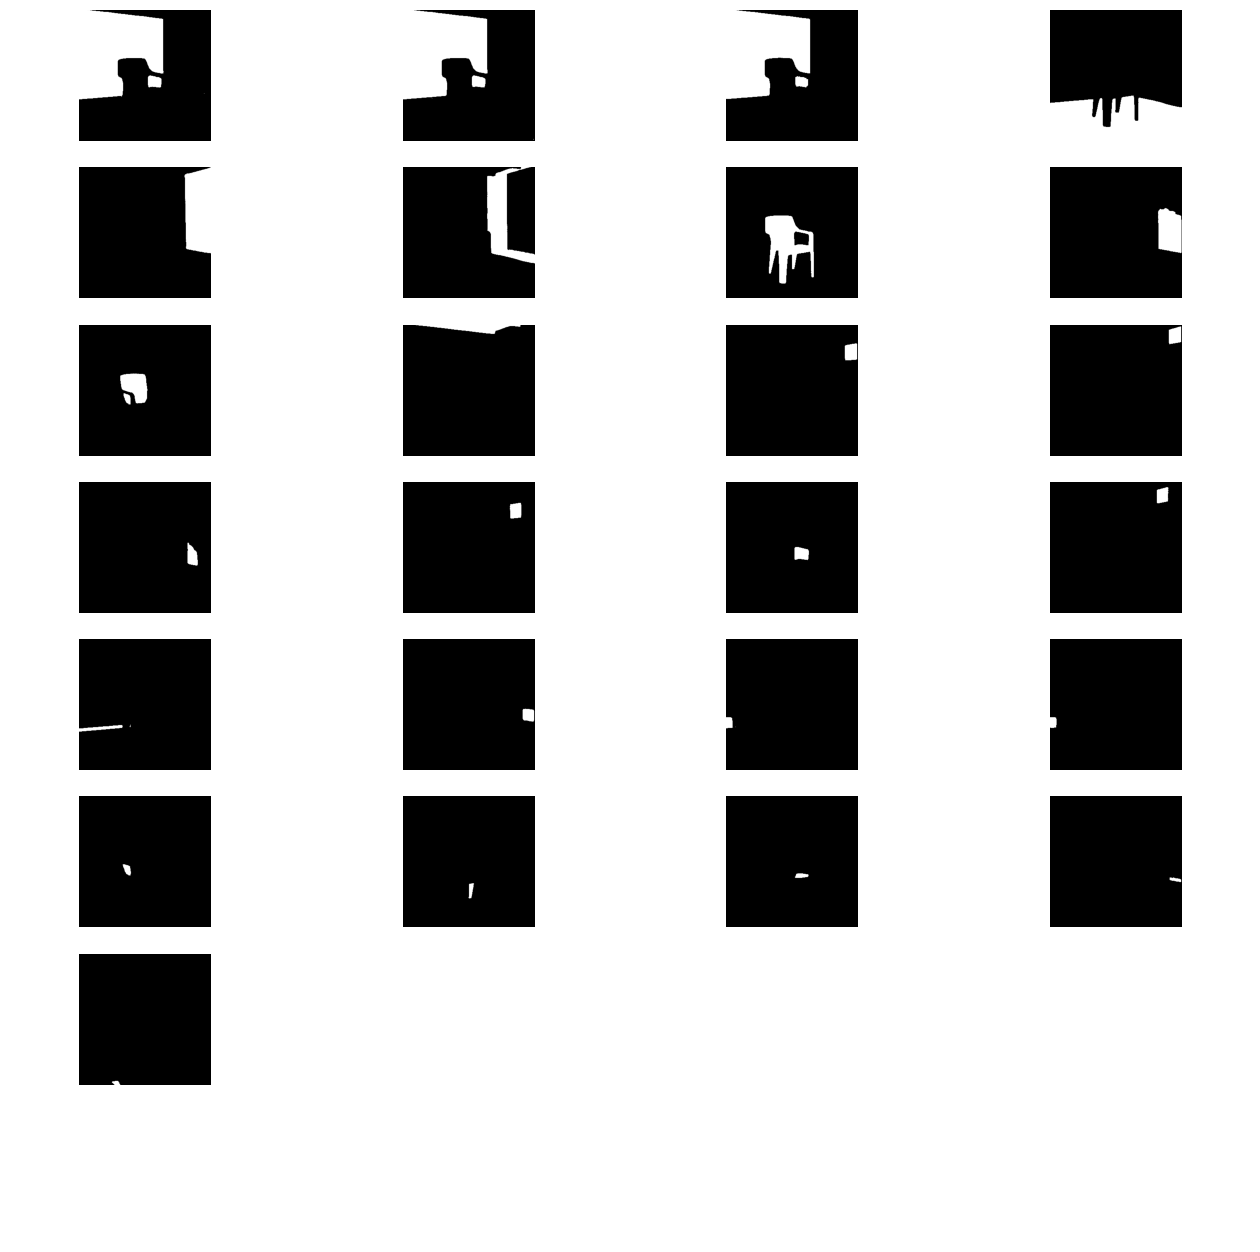

In [ ]:
import math

# Extract masks from sam_result, sorted by area in descending order
masks = [
    mask['segmentation']
    for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

# Dynamically calculate the number of rows needed to fit all masks
n_cols = 8  # Number of columns
n_rows = math.ceil(len(masks) / n_cols)  # Round up to ensure enough rows

# Plot the images in a grid
sv.plot_images_grid(
    images=masks,
    grid_size=(n_cols, n_rows),  # Use dynamic grid size
    size=(16, 16)  # Adjust the overall size of the grid
)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming 'image_bgr' is your original image in BGR format
# and 'masks' contains the segmentation masks sorted by area

# Print the number of detected segments
print(f"Total segments detected: {len(masks)}")

# Highlight the last detected segment if fewer than 7 segments exist
if len(masks) > 0:
    # Use the last mask if there are fewer than 7
    mask_index = min(6, len(masks) - 1)  # Select 6 if there are fewer than 7
    selected_mask = masks[mask_index]  # Get the selected mask

    # Convert the selected mask to a binary mask (0s and 1s)
    binary_mask = np.array(selected_mask, dtype=np.uint8)

    # Create a colored overlay (for example, using red)
    color_overlay = np.zeros_like(image_bgr)
    color_overlay[binary_mask > 0] = [0, 0, 255]  # Red color in BGR format

    # Combine the original image with the overlay
    highlighted_image = cv2.addWeighted(image_bgr, 1, color_overlay, 0.5, 0)

    # Plot the images
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Highlighted Segment')
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
else:
    print("No segments detected.")


Total segments detected: 2


IndexError: boolean index did not match indexed array along dimension 0; dimension is 320 but corresponding boolean dimension is 1

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import supervision as sv  # Assuming sv is the library you're using

# Load a pre-trained object detection model (Faster R-CNN)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")
model.eval()

# Define image transformation for the model input
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the MaskAnnotator from supervision
mask_annotator = sv.MaskAnnotator()

chair_mask = None  # Placeholder to store the chair mask
detections = []  # To store detected chair masks for annotation

# Iterate over each mask segment to check if it contains a chair
for i, mask in enumerate(masks):
    # Convert the mask to a NumPy array if it's a PyTorch tensor
    mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask

    # Remove the extra dimension of the mask (shape should be [320, 320])
    mask_np = np.squeeze(mask_np)  # Now mask has shape (320, 320)

    # Expand mask along the color channel dimension to match (320, 320, 3)
    mask_np_expanded = np.stack([mask_np] * 3, axis=-1)  # Now shape is (320, 320, 3)

    # Multiply the mask with the original image (input_image should have shape (3, 320, 320))
    # Transpose input_image from (3, 320, 320) to (320, 320, 3) for compatibility
    input_image_np = np.transpose(input_image.squeeze().numpy(), (1, 2, 0))  # (320, 320, 3)

    # Apply the mask to the input image
    segmented_image = (input_image_np * mask_np_expanded).astype('uint8')

    # Convert to tensor and apply the required transforms
    input_tensor = transform(segmented_image).unsqueeze(0)  # Add batch dimension

    # Run the object detection model
    with torch.no_grad():
        predictions = model(input_tensor)

    # Check if any of the detected objects is a chair (COCO class 56 is "chair")
    labels = predictions[0]['labels']
    if 56 in labels:  # '56' is the COCO dataset ID for 'chair'
        chair_mask = mask_np
        detections.append({'mask': chair_mask, 'label': 'chair'})  # Store for annotation
        print(f"Chair detected in mask {i}")
        break

# Annotate the image with the detected chair mask if found
if chair_mask is not None:
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Plot the original and annotated images side by side
    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['Source Image', 'Annotated Image (Chair Detected)']
    )
else:
    print("No chair was detected in the given segments.")


No chair was detected in the given segments.


In [ ]:
# COCO class labels
COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
    "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet",
    "TV", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Check if chair is detected
chair_class_id = 56  # COCO class ID for 'chair'
detected_chairs = [(label.item(), score.item()) for label, score in zip(labels, scores) if label == chair_class_id and score > confidence_threshold]


NameError: name 'scores' is not defined

TypeError: Invalid shape (1, 320, 320) for image data

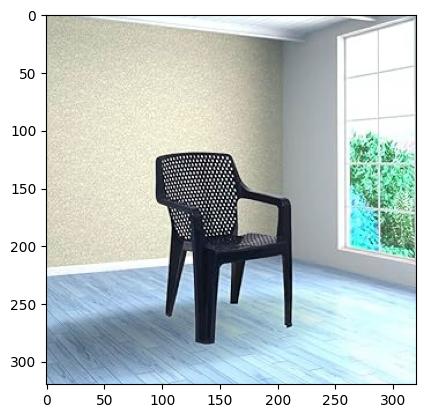

In [ ]:
# Visualize the original image and the masks
plt.imshow(image_bgr)  # Display original image
for mask in masks:
    plt.imshow(mask.cpu().numpy(), alpha=0.5)  # Overlay masks
plt.axis('off')
plt.show()


In [ ]:
import numpy as np

box = np.array([68, 247, 623, 925])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
import numpy as np

# Assuming sam_result contains multiple detections and you want to assign a single class ID for all
num_detections = len(sam_result)
class_ids = np.zeros(num_detections)  # Assign class ID 0 to all detections

# Create the detections object with dummy class IDs
detections = sv.Detections.from_sam(sam_result=sam_result)
detections.class_id = class_ids  # Assign the dummy class IDs
# Example: Assigning class IDs based on specific logic (adjust as necessary)
class_ids = np.random.randint(0, 3, size=num_detections)  # Randomly assigning class IDs 0, 1, or 2
detections.class_id = class_ids


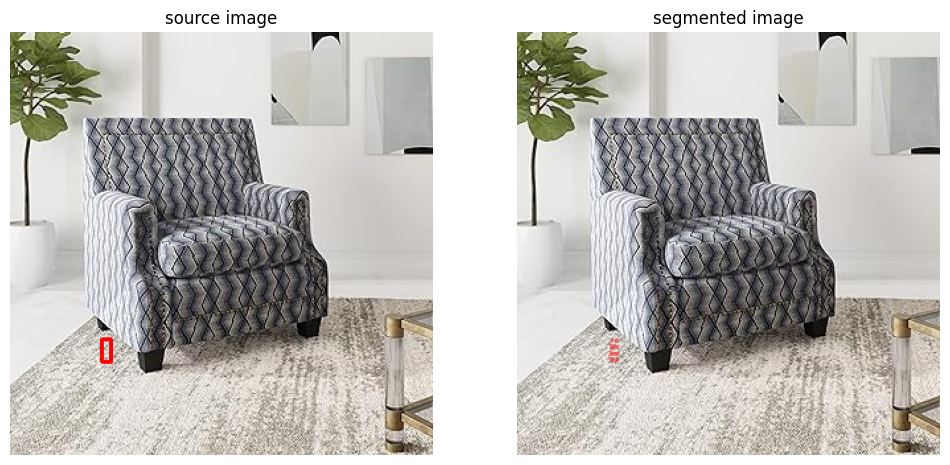

In [ ]:
# Create the Box and Mask Annotators with red color
box_annotator = sv.BoxAnnotator(color=sv.Color(255, 0, 0))  # Correctly creating a Color object
mask_annotator = sv.MaskAnnotator(color=sv.Color(255, 0, 0))  # Correctly creating a Color object

# Create detections from masks
# Assuming a dummy class ID of 0 for all detections
class_ids = np.zeros(len(masks), dtype=int)  # Array of zeros, assuming all masks belong to class 0

# Create the Detections object
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks,
    class_id=class_ids  # Include the dummy class IDs
)

# Filter detections for the largest area
detections = detections[detections.area == np.max(detections.area)]

# Annotate the source image
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Plot the images
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [ ]:
sofa_mask = masks[-1]

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


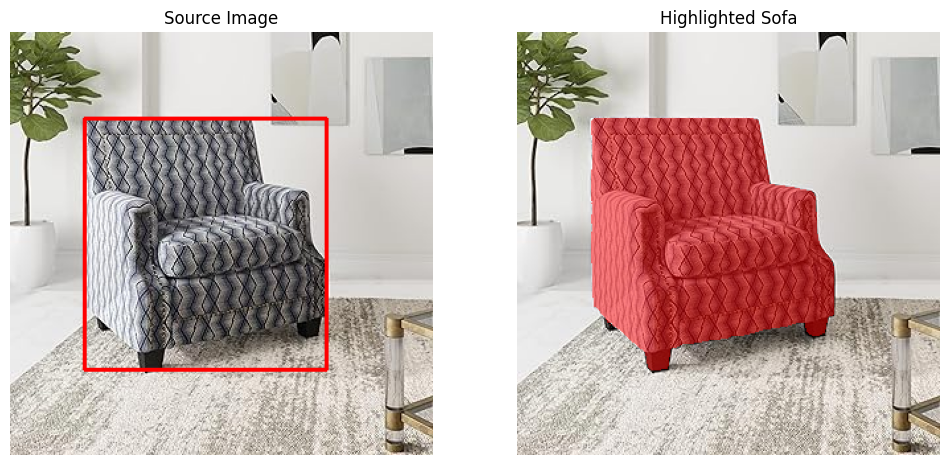

In [ ]:
import os
import cv2
import numpy as np
import math
import supervision as sv

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = "/content/sofa.jpg"

# Load the image
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Generate masks
sam_result = mask_generator.generate(image_rgb)
print(sam_result[0].keys())

# Extract masks from sam_result, sorted by area in descending order
masks = [
    mask['segmentation']
    for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)  # Sort in descending order
]

# Check if masks are found
if masks:
    # Convert list of masks to a NumPy array
    masks_np = np.array(masks)  # Ensure masks are in the correct format

    # Create the Box and Mask Annotators with red color
    box_annotator = sv.BoxAnnotator(color=sv.Color(255, 0, 0))  # Box color
    mask_annotator = sv.MaskAnnotator(color=sv.Color(255, 0, 0))  # Mask color

    # Create detections from masks
    class_ids = np.zeros(len(masks_np), dtype=int)  # Array of zeros for class IDs

    # Create the Detections object
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks_np),  # Use the NumPy array of masks
        mask=masks_np,  # Pass the masks as NumPy array
        class_id=class_ids  # Include the dummy class IDs
    )

    # Filter detections for the largest area (sofa)
    detections = detections[detections.area == np.max(detections.area)]

    # Annotate the source image
    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Plot the images
    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['Source Image', 'Highlighted Sofa']
    )
else:
    print("No masks found.")


Processing /content/chair.jpg, found 25 masks.


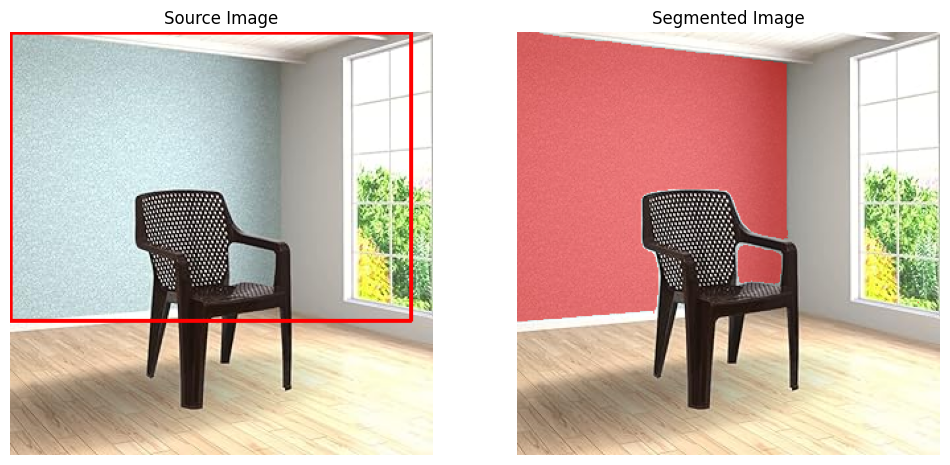

In [ ]:
import os
import cv2
import numpy as np
import glob
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Configuration
CHECKPOINT_PATH = os.path.join('/content', 'weights', 'sam_vit_h_4b8939.pth')  # Specify your model checkpoint path
MODEL_TYPE = "vit_h"  # Model type (adjust as necessary)

# Setup device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the segmentation model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def segment_image(image_path, mask_generator):
    # Load the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using the segmentation model
    sam_result = mask_generator.generate(image_rgb)  # Generate segmentation masks
    print(f"Processing {image_path}, found {len(sam_result)} masks.")

    # Extract masks from sam_result, sorted by area in descending order
    masks = [
        mask['segmentation']
        for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)  # Sort in descending order
    ]

    # Check if masks are found
    if masks:
        # Convert list of masks to a NumPy array
        masks_np = np.array(masks)  # Ensure masks are in the correct format

        # Create the Box and Mask Annotators with red color
        box_annotator = sv.BoxAnnotator(color=sv.Color(255, 0, 0))  # Box color
        mask_annotator = sv.MaskAnnotator(color=sv.Color(255, 0, 0))  # Mask color

        # Create detections from masks
        class_ids = np.zeros(len(masks_np), dtype=int)  # Array of zeros for class IDs

        # Create the Detections object
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks_np),  # Use the NumPy array of masks
            mask=masks_np,  # Pass the masks as NumPy array
            class_id=class_ids  # Include the dummy class IDs
        )

        # Filter detections for the largest area
        if detections:
            detections = detections[detections.area == np.max(detections.area)]

            # Annotate the source image
            source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
            segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

            # Plot the images
            sv.plot_images_grid(
                images=[source_image, segmented_image],
                grid_size=(1, 2),
                titles=['Source Image', 'Segmented Image']
            )
        else:
            print(f"No valid detections found for image: {image_path}")
    else:
        print(f"No masks found for image: {image_path}")

# Example usage for multiple images
image_files = glob.glob("/content/chair.jpg")  # Adjust the path to your images folder
for img_file in image_files:
    segment_image(img_file, mask_generator)  # Pass the mask generator as an argument


Processing /content/chair.jpg, found 25 masks.


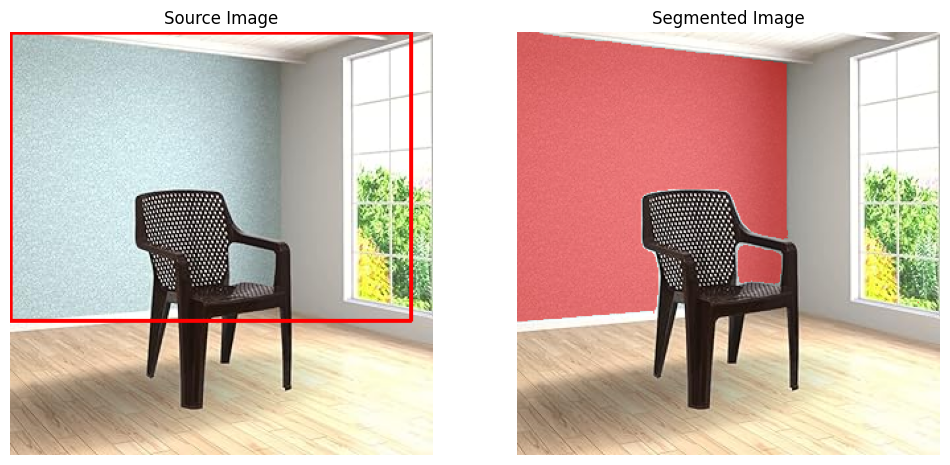

Processing /content/sofa.jpg, found 37 masks.


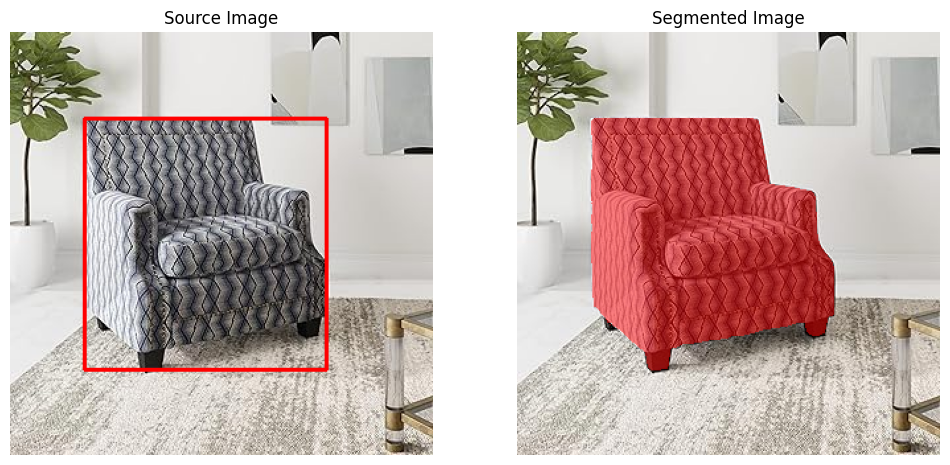

In [ ]:
import os
import cv2
import numpy as np
import glob
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Configuration
CHECKPOINT_PATH = os.path.join('/content', 'weights', 'sam_vit_h_4b8939.pth')  # Specify your model checkpoint path
MODEL_TYPE = "vit_h"  # Model type (adjust as necessary)

# Load the segmentation model
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def segment_image(image_path):
    # Load the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using the segmentation model
    sam_result = mask_generator.generate(image_rgb)
    print(f"Processing {image_path}, found {len(sam_result)} masks.")

    # Extract masks from sam_result, sorted by area in descending order
    masks = [
        mask for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)  # Sort in descending order
    ]

    # Check if masks are found
    if masks:
        # Define criteria for filtering (e.g., minimum area threshold)
        area_threshold = 5000  # Adjust this value based on your requirements
        filtered_masks = [mask['segmentation'] for mask in masks if mask['area'] > area_threshold]

        if filtered_masks:
            # Convert list of masks to a NumPy array
            masks_np = np.array(filtered_masks)  # Ensure masks are in the correct format

            # Create the Box and Mask Annotators with red color
            box_annotator = sv.BoxAnnotator(color=sv.Color(255, 0, 0))  # Box color
            mask_annotator = sv.MaskAnnotator(color=sv.Color(255, 0, 0))  # Mask color

            # Create detections from masks
            class_ids = np.zeros(len(masks_np), dtype=int)  # Array of zeros for class IDs

            # Create the Detections object
            detections = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=masks_np),  # Use the NumPy array of masks
                mask=masks_np,  # Pass the masks as NumPy array
                class_id=class_ids  # Include the dummy class IDs
            )

            # Filter detections for the largest area
            detections = detections[detections.area == np.max(detections.area)]

            # Annotate the source image
            source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
            segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

            # Plot the images
            sv.plot_images_grid(
                images=[source_image, segmented_image],
                grid_size=(1, 2),
                titles=['Source Image', 'Segmented Image']
            )
        else:
            print(f"No valid masks found after filtering for image: {image_path}")
    else:
        print(f"No masks found for image: {image_path}")

# Example usage for multiple images
image_files = glob.glob("/content/*.jpg")  # Adjust the path to your images folder
for img_file in image_files:
    segment_image(img_file)


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ecbqgf1i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ecbqgf1i
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 4.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5a9c96ff633b081b9259eeceba1c9d8f67039dc41e6ebf58eef3413d753334c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-vf_qsxeg/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
!pip install opencv-python
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install diffusers[torch]
!pip install pillow

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7z7yebr6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7z7yebr6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --upgrade diffusers[torch] transformers accelerate

In [ ]:
!pip install opencv-python opencv-python-headless torch torchvision diffusers segment-anything

Processing /content/chair.jpg, found 25 masks.


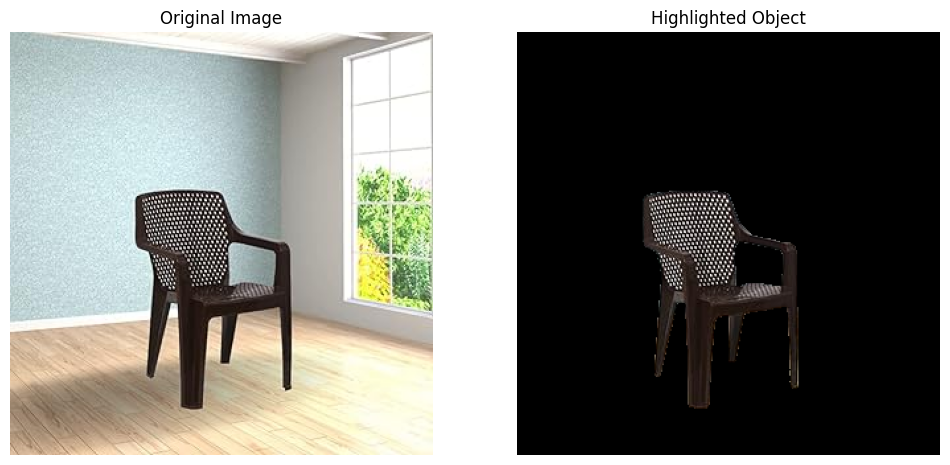

Processing /content/sofa.jpg, found 37 masks.


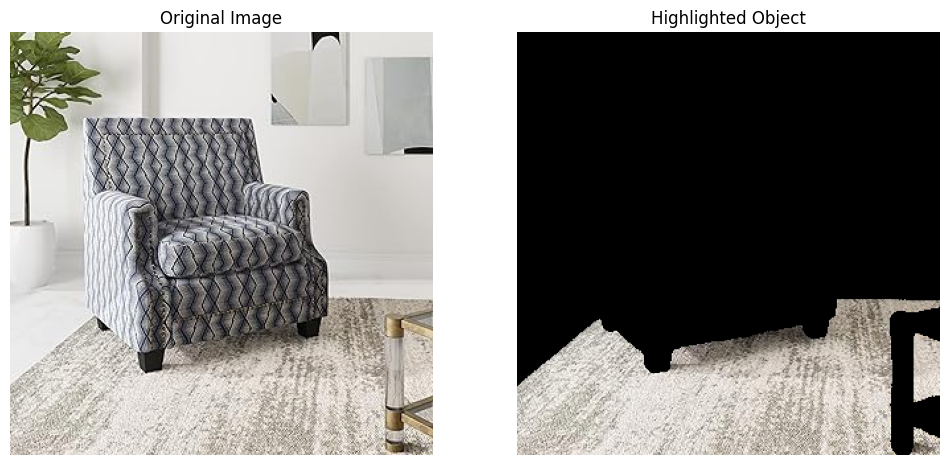

In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def segment_and_highlight(image_path, object_name):
    # Load the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    sam_result = mask_generator.generate(image_rgb)

    # Check if any masks are found
    if not sam_result:
        print(f"No masks found for image: {image_path}")
        return

    # Display the number of masks found
    print(f"Processing {image_path}, found {len(sam_result)} masks.")

    # Create an empty mask for the target object
    target_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Iterate through the masks and find the one that corresponds to the object of interest
    for mask in sam_result:
        segmentation = mask['segmentation']
        # You may implement logic to determine if this mask corresponds to the object name, if available
        # Here we simply use the largest area mask as an example
        if np.sum(segmentation) > np.sum(target_mask):
            target_mask = segmentation.astype(np.uint8) * 255  # Convert mask to 255 for visualization

    # Highlight the target object in the original image
    highlighted_image = cv2.bitwise_and(image_bgr, image_bgr, mask=target_mask)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Highlighted Object")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
object_name = 'chair'  # The object you want to segment
segment_and_highlight(image_path, object_name)
# Example usage
image_path = '/content/sofa.jpg'  # Replace with your image path
object_name = 'chair'  # The object you want to segment
segment_and_highlight(image_path, object_name)

Processing /content/chair.jpg, found 25 masks.


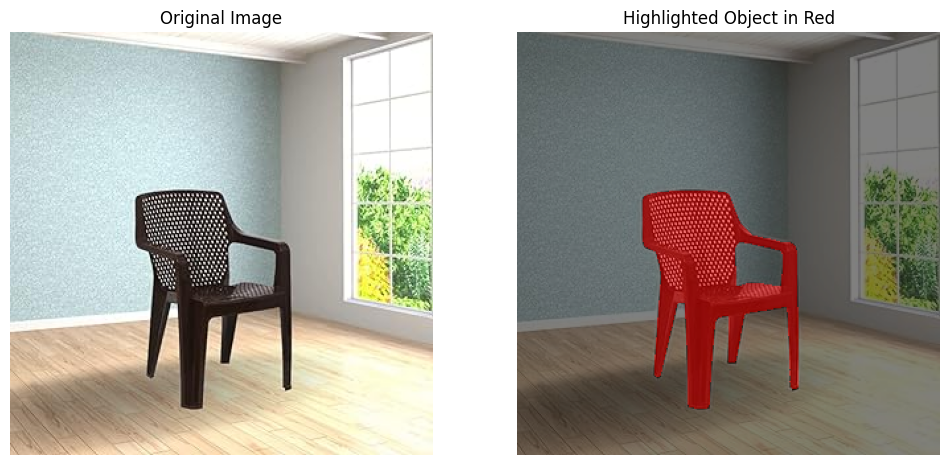

Processing /content/sofa.jpg, found 37 masks.


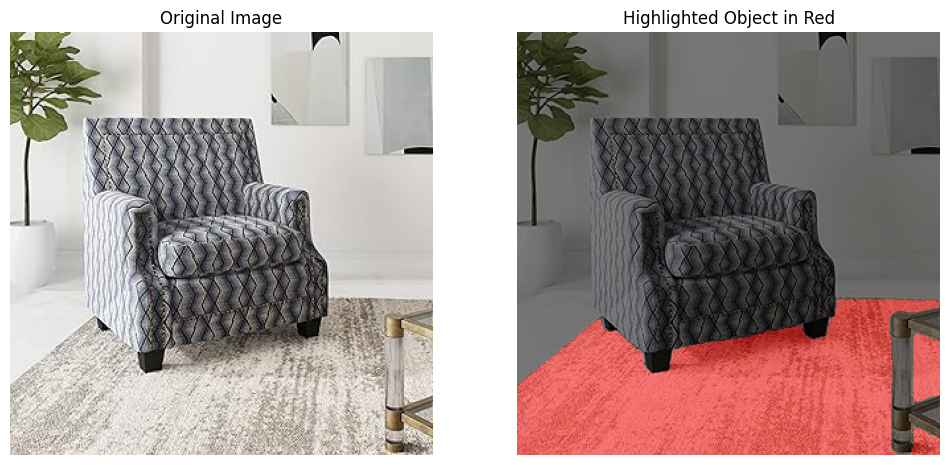

Processing /content/flower vase.jpg, found 14 masks.


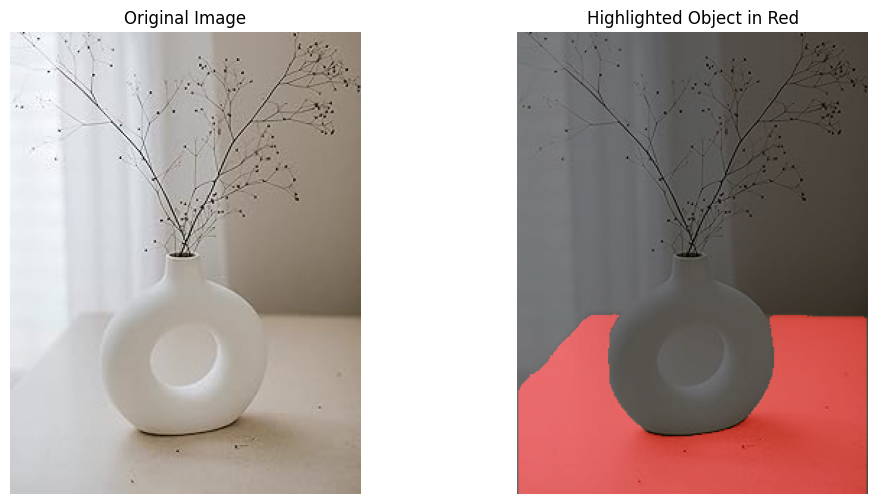

In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def segment_and_highlight(image_path, object_name):
    # Load the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    sam_result = mask_generator.generate(image_rgb)

    # Check if any masks are found
    if not sam_result:
        print(f"No masks found for image: {image_path}")
        return

    # Display the number of masks found
    print(f"Processing {image_path}, found {len(sam_result)} masks.")

    # Create an empty mask for the target object
    target_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Iterate through the masks and find the one that corresponds to the object of interest
    for mask in sam_result:
        segmentation = mask['segmentation']
        # You may implement logic to determine if this mask corresponds to the object name, if available
        # Here we simply use the largest area mask as an example
        if np.sum(segmentation) > np.sum(target_mask):
            target_mask = segmentation.astype(np.uint8) * 255  # Convert mask to 255 for visualization

    # Create a red highlight for the target object
    red_highlight = np.zeros_like(image_bgr)
    red_highlight[:, :, 0] = 0  # Set Blue channel to 0
    red_highlight[:, :, 1] = 0  # Set Green channel to 0
    red_highlight[:, :, 2] = 255  # Set Red channel to 255

    # Blend the original image with the red highlight using the mask
    highlighted_image = cv2.bitwise_and(red_highlight, red_highlight, mask=target_mask)
    highlighted_image = cv2.addWeighted(highlighted_image, 0.5, image_bgr, 0.5, 0)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Highlighted Object in Red")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
object_name = 'chair'  # The object you want to segment
segment_and_highlight(image_path, object_name)
image_path = '/content/sofa.jpg'  # Replace with your image path
object_name = 'sofa'  # The object you want to segment
segment_and_highlight(image_path, object_name)
image_path = '/content/flower vase.jpg'  # Replace with your image path
object_name = 'flower vase'  # The object you want to segment
segment_and_highlight(image_path, object_name)

In [ ]:
!pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install opencv-python-headless
!pip install matplotlib
!pip install -U 'git+https://github.com/ultralytics/yolov5.git'
!pip install segment-anything
!pip install supervision

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Cloning https://github.com/ultralytics/yolov5.git to /tmp/pip-req-build-4akvwzgi
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov5.git /tmp/pip-req-build-4akvwzgi
  Resolved https://github.com/ultralytics/yolov5.git to commit 907bef2f63771a352346d0b4f068946d7f961f0c
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


Number of masks generated: 25


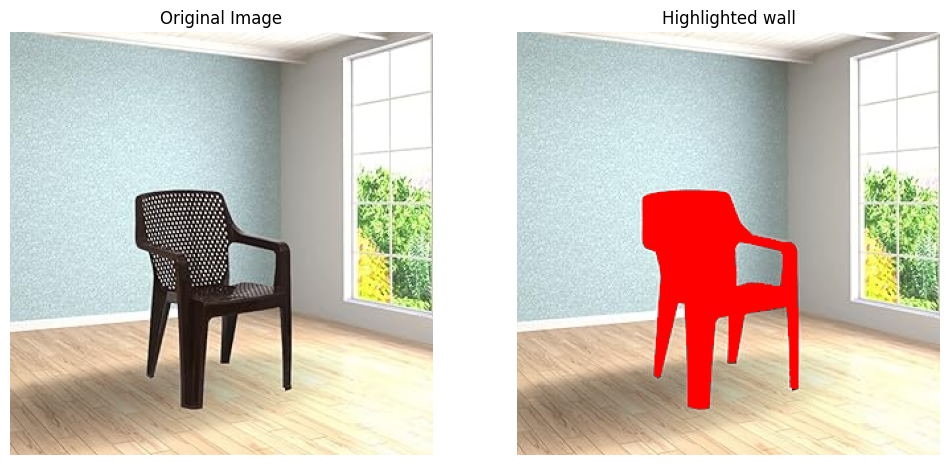

Number of masks generated: 37


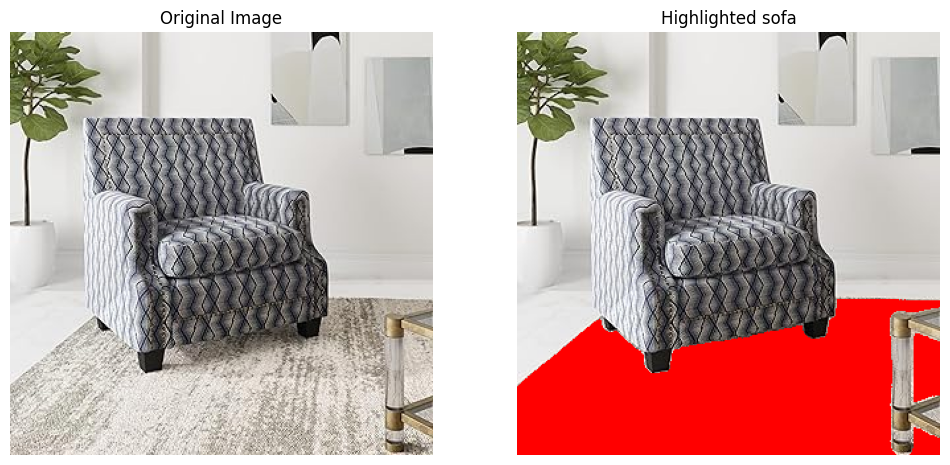

In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def segment_and_highlight(image_path, object_name):
    # Load the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using the segmentation model
    sam_result = mask_generator.generate(image_rgb)

    # Prepare a mask for highlighting the specified object
    highlighted_mask = np.zeros_like(image_rgb[:, :, 0], dtype=np.uint8)  # Create a blank mask

    # Display the segmented objects for debugging
    print(f"Number of masks generated: {len(sam_result)}")

    # Manually select the masks to highlight based on your knowledge of the image
    for mask in sam_result:
        segmentation = mask['segmentation']
        # Optionally, you could implement logic here to match based on some criteria
        # (e.g., size or location). Here we'll just highlight the first mask for demonstration.
        highlighted_mask[segmentation] = 255  # Set mask region to white
        break  # Remove this if you want to keep highlighting more masks

    # Create a red-highlighted image
    highlighted_image = image_bgr.copy()
    highlighted_image[highlighted_mask > 0] = [0, 0, 255]  # Set highlighted areas to red

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Highlighted {object_name}")
    plt.axis("off")

    plt.show()

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
object_name = 'chair'  # The object you want to segment
segment_and_highlight(image_path, object_name)
# Example usage
image_path = '/content/sofa.jpg'  # Replace with your image path
object_name = 'mat'  # The object you want to segment
segment_and_highlight(image_path, object_name)

In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -U 'git+https://github.com/ultralytics/yolov5.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0e840tb7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0e840tb7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/ultralytics/yolov5.git to /tmp/pip-req-build-f7gcr42b
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov5.git /tmp/pip-req-build-f7gcr42b
  Resolved https://github.com/ultralytics/yolov5.git to commit 907bef2f63771a352346d0b4f068946d7f961f0c
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getti

In [ ]:
import torch
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Load SAM model
CHECKPOINT_PATH = os.path.join('/content', 'weights', 'sam_vit_h_4b8939.pth')
sam_checkpoint = CHECKPOINT_PATH  # You can change this path as needed
MODEL_TYPE = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize SAM
sam = sam_model_registry[MODEL_TYPE](checkpoint=sam_checkpoint).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load YOLOv5s model (pre-trained weights)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.eval()  # Set model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 182.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 3.3s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-10-2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 216MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Load SAM model
#sam_checkpoint = 'sam_vit_h_4b8939.pth'  # Change this path as needed
MODEL_TYPE = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize SAM
sam = sam_model_registry[MODEL_TYPE](checkpoint=sam_checkpoint).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load YOLOv5s model (pre-trained weights)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.eval()  # Set model to evaluation mode


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-2 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
image_path = '/content/chair.jpg'  # Replace with your image path
object_name = 'chair'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Step 1: Generate masks using SAM
sam_result = mask_generator.generate(image_rgb)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set the image path and object name
image_path = '/content/chair.jpg'  # Replace with your image path
object_name = 'chair'  # The object you want to segment

# Load the image
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    print("Error: Image not found. Please check the image path.")
else:
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Close the figure to free memory
    plt.close()

Error: Image not found. Please check the image path.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_and_highlight(image_path, object_name):
    # Load the image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print("Error: Image not found. Please check the image path.")
        return

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Step 2: Perform object detection using YOLOv5
    results = yolo_model(image_rgb)  # Ensure your YOLOv5 model is correctly loaded
    detections = results.pandas().xyxy[0]  # Get detections as a pandas DataFrame
    print("Detections:\n", detections)  # Debugging: print the detections

    # Prepare a mask for highlighting the specified object
    highlighted_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)  # Create a blank mask
    found = False

    # Check if the specified object name is in the detections
    for _, detection in detections.iterrows():
        print("Current Detection:\n", detection)  # Debugging: print each detection
        if detection['name'].lower() == object_name.lower():  # Match the detected object with the specified object
            found = True
            x_min, y_min, x_max, y_max = (int(detection['xmin']), int(detection['ymin']),
                                           int(detection['xmax']), int(detection['ymax']))
            print(f'Detected {object_name}: {x_min}, {y_min}, {x_max}, {y_max}')  # Debugging coordinates

            # Create a mask from the bounding box coordinates
            highlighted_mask[y_min:y_max, x_min:x_max] = 255  # Set mask region to white

    # Debugging: Check the highlighted_mask shape and unique values
    print("Highlighted mask shape:", highlighted_mask.shape)
    print("Unique values in highlighted_mask:", np.unique(highlighted_mask))

    # Highlight the detected object if found
    highlighted_image = image_bgr.copy()
    if found:
        # Use the highlighted mask to set the areas to red in the highlighted_image
        highlighted_image[highlighted_mask > 0] = [0, 0, 255]  # Set highlighted areas to red
    else:
        print(f"No '{object_name}' found in the image.")

    # Resize images for better visualization
    original_image_resized = cv2.resize(image_rgb, (640, 480))
    highlighted_image_resized = cv2.resize(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB), (640, 480))

    # Display the highlighted image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_resized)
    plt.title("Original Image Resized")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image_resized)
    plt.title(f"Highlighted {object_name}")
    plt.axis("off")

    plt.show()
    print("Processing complete.")

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
object_name = 'chair'  # The object you want to segment
segment_and_highlight(image_path, object_name)

Detections:
         xmin        ymin        xmax      ymax  confidence  class   name
0  95.402023  119.105232  214.483658  290.4328    0.843067     56  chair
Current Detection:
 xmin           95.402023
ymin          119.105232
xmax          214.483658
ymax            290.4328
confidence      0.843067
class                 56
name               chair
Name: 0, dtype: object
Detected chair: 95, 119, 214, 290
Highlighted mask shape: (320, 320)
Unique values in highlighted_mask: [  0 255]
Processing complete.


**NEW APPROACH---------------------------------------------**

In [ ]:
!pip install torch torchvision opencv-python matplotlib
!git clone https://github.com/facebookresearch/segment-anything.git
!cd segment-anything
!pip install -r requirements.txt


Cloning into 'segment-anything'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 304 (delta 2), reused 3 (delta 1), pack-reused 298 (from 1)
Receiving objects: 100% (304/304), 18.31 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (159/159), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!pip install requests
!pip install --upgrade segment-anything


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry

# Load the SAM model
model_type = "vit_h"  # Change this to your model type (e.g., vit_b, vit_l, or vit_h)
sam_checkpoint = "/content/weights/sam_vit_h_4b8939.pth"  # Update with your checkpoint path

# Initialize the model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)

# Load the image
image_path = "/content/chair.jpg"  # Update with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:

# Prepare the input for the model
input_image = torch.from_numpy(image_rgb).permute(2, 0, 1).unsqueeze(0).float().to(device)  # Shape: (1, 3, H, W)

# Prepare the batched input as a list of dictionaries
batched_input = [{"image": input_image}]

# Run segmentation with multimask_output=True
with torch.no_grad():  # Disable gradient calculations
    sam_result = sam(batched_input, multimask_output=True)  # Call the model with batched input

# Extract masks from sam_result, assuming the output is a list of dictionaries
masks = [
    mask['segmentation']
    for mask in sorted(sam_result['masks'], key=lambda x: x['area'], reverse=True)  # Sort by area if needed
]

# Dynamically calculate the number of rows needed to fit all masks
n_cols = 8  # Number of columns
n_rows = math.ceil(len(masks) / n_cols)  # Round up to ensure enough rows

# Plot the images in a grid
plt.figure(figsize=(20, 20))
for i, mask in enumerate(masks):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(mask, cmap='gray')  # Show the mask
    plt.axis('off')
plt.tight_layout()
plt.show()


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 1024, 1024]

In [ ]:
pip install torch torchvision torchaudio opencv-python

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-3 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.29905539751052856, 0.3712027668952942, 0.6670712232589722, 0.9037613868713379)


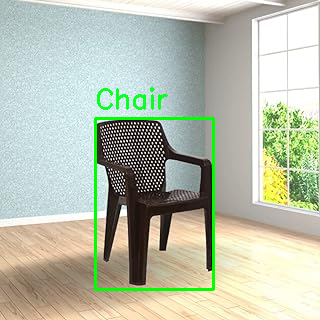

In [ ]:
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab-specific function to display images

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to detect a chair in an image
def detect_chair(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Perform inference
    results = model(img)

    # Get the results (bounding boxes, labels, and scores)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    # Initialize a flag to check if 'chair' is detected
    chair_detected = False

    # Iterate through detected objects
    for label, cord in zip(labels, cords):
        # Check if the label is "chair"
        if model.names[int(label)] == 'chair':
            chair_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"Chair detected with confidence {conf:.2f} at location: ({x1}, {y1}, {x2}, {y2})")

            # Optionally, draw bounding boxes on the image
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, 'Chair', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the image with bounding box
    if chair_detected:
        cv2_imshow(img)  # Use cv2_imshow() instead of cv2.imshow() for Colab
    else:
        print("No chair detected.")

# Example usage
image_path = '/content/chair.jpg'  # Update with your image path
detect_chair(image_path)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-3 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)


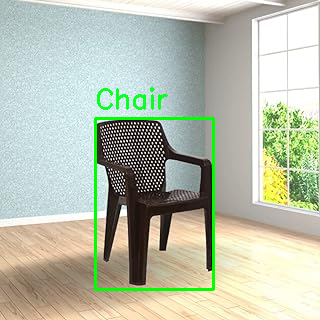

In [ ]:
import torch
import cv2
from google.colab.patches import cv2_imshow  # Colab-specific function to display images

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to detect a specified object in an image
def detect_object(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)

    # Perform inference
    results = model(img)

    # Get the results (bounding boxes, labels, and scores)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    # Initialize a flag to check if the target object is detected
    object_detected = False

    # Iterate through detected objects
    for label, cord in zip(labels, cords):
        # Check if the label matches the target object
        if model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Optionally, draw bounding boxes on the image
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, target_object.capitalize(), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the image with bounding box
    if object_detected:
        cv2_imshow(img)  # Use cv2_imshow() instead of cv2.imshow() for Colab
    else:
        print(f"No {target_object} detected.")

# Example usage
#target_object = input("Enter the object to detect (e.g., 'chair'): ").strip().lower()  # Ask for the object
#image_path = input("Enter the image path: ").strip()  # Ask for the image path
target_object = 'chair'
image_path = '/content/chair.jpg'
detect_object(image_path, target_object)


In [ ]:
!pip install opencv-python
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ssqcgd20
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ssqcgd20
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=fad15da57ea9743891f043a58940902d41e15d33bdabf81704176de6076218e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-obepp9o9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [ ]:
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab-specific function to display images
from segment_anything import sam_model_registry  # Import SAM model registry

# Load the YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load the SAM model
sam_checkpoint = "/content/weights/sam_vit_h_4b8939.pth"  # Path to your SAM model checkpoint
sam_type = "vit_h"  # Specify the model type
sam = sam_model_registry[sam_type](checkpoint=sam_checkpoint)

# Function to preprocess image and detect/segment objects
def detect_and_segment(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for consistency

    # Perform inference with YOLOv5
    results = yolo_model(img_rgb)

    # Get the results (bounding boxes, labels, and scores)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    # Initialize a flag to check if the target object is detected
    object_detected = False

    # Iterate through detected objects
    for label, cord in zip(labels, cords):
        # Check if the label matches the target object
        if yolo_model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Convert normalized coordinates to pixel values
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)

            # Prepare the input for SAM based on the bounding box
            # Here, we need to create a point from the bounding box coordinates
            point = np.array([[x1 + (x2 - x1) // 2, y1 + (y2 - y1) // 2]])  # Center of the bounding box

            # Ensure that the input to SAM is in the correct format
            input_image = torch.tensor(img_rgb).permute(2, 0, 1).unsqueeze(0)  # Change HWC to CHW and add batch dimension

            # Generate masks with the SAM model
            masks, scores, logits = sam(input_image, point)  # Using the point as input

            # Draw the masks
            if masks is not None and len(masks) > 0:
                # Create an overlay for the mask
                for mask in masks:
                    mask_image = mask.astype(np.uint8) * 255  # Ensure mask is binary
                    mask_colored = cv2.applyColorMap(mask_image, cv2.COLORMAP_JET)  # Color the mask
                    img = cv2.addWeighted(img, 0.5, mask_colored, 0.5, 0)  # Overlay the mask

            # Draw bounding box around detected object
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, target_object.capitalize(), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the image with highlighted segments
    if object_detected:
        cv2_imshow(img)  # Use cv2_imshow() instead of cv2.imshow() for Colab
    else:
        print(f"No {target_object} detected.")

# Example usage
target_object = 'chair'
image_path = '/content/chair.jpg'
detect_and_segment(image_path, target_object)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-3 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.84 at location: (0.30, 0.37, 0.67, 0.91)


IndexError: too many indices for tensor of dimension 3

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-3 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)


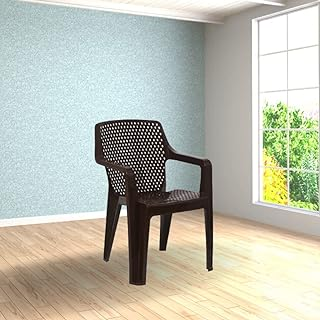

In [ ]:
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab-specific function to display images
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Configuration for SAM
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def detect_object(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)

    # Perform inference
    results = yolo_model(img)

    # Get the results (bounding boxes, labels, and scores)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    # Initialize a flag to check if the target object is detected
    object_detected = False

    # Iterate through detected objects
    for label, cord in zip(labels, cords):
        # Check if the label matches the target object
        if yolo_model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Convert YOLO coordinates to image pixel coordinates
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)

            # Crop the detected object region
            cropped_img = img[y1:y2, x1:x2]
            apply_sam_segmentation(cropped_img)

    # Display the image with bounding box
    if object_detected:
        cv2_imshow(img)  # Use cv2_imshow() instead of cv2.imshow() for Colab
    else:
        print(f"No {target_object} detected.")

def apply_sam_segmentation(cropped_image):
    # Convert to RGB
    cropped_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    sam_result = mask_generator.generate(cropped_rgb)

    # Check if any masks are found
    if not sam_result:
        print("No masks found for the cropped image.")
        return

    # Process the masks to create a highlighted version of the object
    target_mask = np.zeros_like(cropped_rgb, dtype=np.uint8)

    for mask in sam_result:
        segmentation = mask['segmentation']
        # Here, you might want to implement more complex logic to identify the correct mask
        if np.sum(segmentation) > np.sum(target_mask):
            target_mask = segmentation.astype(np.uint8) * 255

    # Create a red highlight for the target object
    red_highlight = np.zeros_like(cropped_image)
    red_highlight[:, :, 0] = 0  # Set Blue channel to 0
    red_highlight[:, :, 1] = 0  # Set Green channel to 0
    red_highlight[:, :, 2] = 255  # Set Red channel to 255

    # Blend the original image with the red highlight using the mask
    highlighted_image = cv2.bitwise_and(red_highlight, red_highlight, mask=target_mask)
    highlighted_image = cv2.addWeighted(highlighted_image, 0.5, cropped_image, 0.5, 0)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Cropped Image")
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Highlighted Object in Red")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
target_object = 'chair'  # The object you want to segment
detect_object(image_path, target_object)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-3 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)


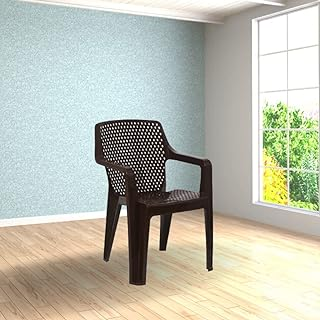

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Colab-specific function to display images
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Configuration for SAM
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def detect_object(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)

    # Perform inference
    results = yolo_model(img)

    # Get the results (bounding boxes, labels, and scores)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    # Initialize a flag to check if the target object is detected
    object_detected = False

    # Iterate through detected objects
    for label, cord in zip(labels, cords):
        # Check if the label matches the target object
        if yolo_model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Convert YOLO coordinates to image pixel coordinates
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)

            # Crop the detected object region
            cropped_img = img[y1:y2, x1:x2]
            apply_sam_segmentation(cropped_img)

    # Display the image with bounding box
    if object_detected:
        cv2_imshow(img)  # Use cv2_imshow() instead of cv2.imshow() for Colab
    else:
        print(f"No {target_object} detected.")

def apply_sam_segmentation(cropped_image):
    # Convert to RGB
    cropped_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    sam_result = mask_generator.generate(cropped_rgb)

    # Check if any masks are found
    if not sam_result:
        print("No masks found for the cropped image.")
        return

    # Create an empty mask for the target object
    target_mask = np.zeros(cropped_rgb.shape[:2], dtype=np.uint8)

    for mask in sam_result:
        segmentation = mask['segmentation']
        # Here, you might want to implement more complex logic to identify the correct mask
        if np.sum(segmentation) > np.sum(target_mask):
            target_mask = segmentation.astype(np.uint8)  # Keep as binary mask (0 or 1)

    # Create a red mask for highlighting
    red_highlight = np.zeros_like(cropped_image)
    red_highlight[:, :, 0] = 0    # Blue channel
    red_highlight[:, :, 1] = 0    # Green channel
    red_highlight[:, :, 2] = 255  # Red channel

    # Use the target mask to highlight the object in red
    highlighted_image = cv2.bitwise_and(red_highlight, red_highlight, mask=target_mask)  # Highlighted red only on the mask
    highlighted_image = cv2.addWeighted(highlighted_image, 1, cropped_image, 0.5, 0)  # Blend with original image

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Cropped Image")
    plt.imshow(cropped_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Highlighted Object in Red")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
target_object = 'chair'  # The object you want to segment
detect_object(image_path, target_object)


In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to detect an object, segment it using SAM, and display it in red
def detect_and_segment(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)

    # Detect objects using YOLOv5
    results = model(img)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    object_detected = False

    # Iterate through detected objects to find the target object
    for label, cord in zip(labels, cords):
        if model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Extract ROI
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            roi = img[y1:y2, x1:x2]
            print("Region of Interest (ROI) extracted.")

            # Segment the ROI using SAM
            image_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            sam_result = mask_generator.generate(image_rgb)
            if not sam_result:
                print("No segments found in the ROI.")
                return

            # Display the number of segments found
            print(f"Found {len(sam_result)} segments.")

            # Find and apply the largest mask
            largest_mask = None
            max_area = 0
            for mask in sam_result:
                segmentation = mask['segmentation']
                area = np.sum(segmentation)
                if area > max_area:
                    max_area = area
                    largest_mask = segmentation.astype(np.uint8) * 255

            print(f"Applying the largest mask with area {max_area}.")

            # Create a red highlight for the segmented object
            red_highlight = np.zeros_like(roi)
            red_highlight[:, :, 2] = 255  # Set Red channel to 255

            # Blend the original ROI with the red highlight using the mask
            highlighted_roi = cv2.bitwise_and(red_highlight, red_highlight, mask=largest_mask)
            highlighted_roi = cv2.addWeighted(highlighted_roi, 0.5, roi, 0.5, 0)

            # Replace the ROI in the original image with the highlighted version
            img[y1:y2, x1:x2] = highlighted_roi

            # Display the final image with red-highlighted object using matplotlib
            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"{target_object.capitalize()} Segmented and Highlighted in Red")
            plt.axis('off')
            plt.show()
            break

    if not object_detected:
        print(f"No {target_object} detected.")

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
target_object = 'chair'  # The object you want to segment
detect_and_segment(image_path, target_object)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-3 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)
Region of Interest (ROI) extracted.
Found 75 segments.
Applying the largest mask with area 9803.


In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to detect an object, segment it using SAM, and display it in red
def detect_and_segment(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)

    # Detect objects using YOLOv5
    results = model(img)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    object_detected = False

    # Iterate through detected objects to find the target object
    for label, cord in zip(labels, cords):
        if model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Extract ROI
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            roi = img[y1:y2, x1:x2]
            print("Region of Interest (ROI) extracted.")

            # Segment the ROI using SAM
            image_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            sam_result = mask_generator.generate(image_rgb)
            if not sam_result:
                print("No segments found in the ROI.")
                return

            # Display the number of segments found
            print(f"Found {len(sam_result)} segments.")

            # Find and apply the largest mask
            largest_mask = None
            max_area = 0
            for mask in sam_result:
                segmentation = mask['segmentation']
                area = np.sum(segmentation)
                if area > max_area:
                    max_area = area
                    largest_mask = segmentation.astype(np.uint8) * 255

            print(f"Applying the largest mask with area {max_area}.")

            # Create a red highlight for the segmented object
            red_highlight = np.zeros_like(roi)
            red_highlight[:, :, 2] = 255  # Set Red channel to 255

            # Blend the original ROI with the red highlight using the mask
            highlighted_roi = cv2.bitwise_and(red_highlight, red_highlight, mask=largest_mask)
            highlighted_roi = cv2.addWeighted(highlighted_roi, 0.5, roi, 0.5, 0)

            # Replace the ROI in the original image with the highlighted version
            img[y1:y2, x1:x2] = highlighted_roi

            # Save and display the final image with red-highlighted object
            cv2.imwrite('/content/highlighted_image1.jpg', img)
            print("Image with segmented object saved as 'highlighted_image.jpg'.")
            break

    if not object_detected:
        print(f"No {target_object} detected.")

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
target_object = 'chair'  # The object you want to segment
detect_and_segment(image_path, target_object)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)
Region of Interest (ROI) extracted.
Found 75 segments.
Applying the largest mask with area 9803.
Image with segmented object saved as 'highlighted_image.jpg'.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/chair.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale and apply thresholding
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# Find contours and create a mask
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(image)

if contours:
    # Draw the largest contour
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Extract the object
segmented_object = cv2.bitwise_and(image, mask)

# Display the original and segmented image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Segmented Object")
plt.imshow(segmented_object)
plt.axis('off')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

def segment_and_highlight(image_path, object_name):
    # Load the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    sam_result = mask_generator.generate(image_rgb)

    # Check if any masks are found
    if not sam_result:
        print(f"No masks found for image: {image_path}")
        return

    # Display the number of masks found
    print(f"Processing {image_path}, found {len(sam_result)} masks.")

    # Create an empty mask for the target object
    target_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Iterate through the masks and find the one that corresponds to the object of interest
    for mask in sam_result:
        segmentation = mask['segmentation']
        # You may implement logic to determine if this mask corresponds to the object name, if available
        # Here we simply use the largest area mask as an example
        if np.sum(segmentation) > np.sum(target_mask):
            target_mask = segmentation.astype(np.uint8) * 255  # Convert mask to 255 for visualization

    # Create a red highlight for the target object
    red_highlight = np.zeros_like(image_bgr)
    red_highlight[:, :, 0] = 0  # Set Blue channel to 0
    red_highlight[:, :, 1] = 0  # Set Green channel to 0
    red_highlight[:, :, 2] = 255  # Set Red channel to 255

    # Blend the original image with the red highlight using the mask
    highlighted_image = cv2.bitwise_and(red_highlight, red_highlight, mask=target_mask)
    highlighted_image = cv2.addWeighted(highlighted_image, 0.5, image_bgr, 0.5, 0)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Highlighted Object in Red")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Directly specify the image path and object name
image_path = '/content/chair.jpg'  # Path to the image
object_name = 'chair'  # The object you want to segment

segment_and_highlight(image_path, object_name)


Processing /content/chair.jpg, found 25 masks.


In [ ]:
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torchvision

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'
MODEL_TYPE = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to detect object, segment it, and highlight the segments
def detect_segment_highlight(image_path, object_name):
    # Load image with OpenCV
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Error: Unable to load image from path {image_path}")
        return

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Step 1: Detect object using YOLOv5
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    results = model(image_rgb)

    # Get the bounding box of the specified object
    detected = False
    for result in results.xyxy[0]:  # For each detection
        label = model.names[int(result[5])]  # Get the label (class name)
        if label == object_name:
            x1, y1, x2, y2 = result[0:4]  # Get bounding box coordinates
            confidence = result[4]  # Confidence score
            print(f"{object_name.capitalize()} detected with confidence {confidence:.2f} at location: {x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f}")
            detected = True
            break

    if not detected:
        print(f"No {object_name} detected in the image.")
        return

    # Step 2: Extract the ROI (Region of Interest)
    roi = image_rgb[int(y1):int(y2), int(x1):int(x2)]  # Crop the region of interest (ROI)
    print("Region of Interest (ROI) extracted.")

    # Step 3: Pass ROI to SAM for segmentation
    masks = mask_generator.generate(roi)
    print(f"Found {len(masks)} segments.")

    # Step 4: Display all the segments separately
    for idx, mask in enumerate(masks):
        segmentation = mask['segmentation'].astype(np.uint8) * 255
        plt.figure()
        plt.title(f"Segment {idx + 1}")
        plt.imshow(segmentation, cmap='gray')
        plt.show()

    # Step 5: Apply red mask to the largest segment
    largest_mask = max(masks, key=lambda x: np.sum(x['segmentation']))
    final_mask = largest_mask['segmentation'].astype(np.uint8) * 255
    red_highlight = np.zeros_like(roi)
    red_highlight[:, :, 2] = 255  # Red channel set to max

    # Apply red mask to the ROI
    highlighted_roi = cv2.bitwise_and(red_highlight, red_highlight, mask=final_mask)
    highlighted_roi = cv2.addWeighted(highlighted_roi, 0.5, roi, 0.5, 0)

    # Step 6: Place the highlighted ROI back into the original image
    image_rgb[int(y1):int(y2), int(x1):int(x2)] = highlighted_roi

    # Display the original image with the segmented object highlighted in red
    plt.figure(figsize=(10, 5))
    plt.title(f"Original Image with {object_name.capitalize()} Highlighted")
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Test the function
image_path = '/content/chair.jpg'
object_name = 'chair'
detect_segment_highlight(image_path, object_name)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.84 at location: 95.40, 119.11, 214.48, 290.43
Region of Interest (ROI) extracted.
Found 83 segments.


<ipython-input-21-d15c14c89f7b>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to detect an object and save the ROI
def detect_and_save_roi(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)

    # Detect objects using YOLOv5
    results = model(img)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    object_detected = False

    # Iterate through detected objects to find the target object
    for label, cord in zip(labels, cords):
        if model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Extract ROI
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            roi = img[y1:y2, x1:x2]
            print("Region of Interest (ROI) extracted.")

            # Save the ROI as a separate image
            roi_output_path = '/content/roi_chair.png'
            cv2.imwrite(roi_output_path, roi)
            print(f"Region of Interest saved as 'roi_chair.png'.")
            break

    if not object_detected:
        print(f"No {target_object} detected.")

# Example usage
image_path = '/content/chair.jpg'  # Replace with your image path
target_object = 'chair'  # The object you want to save
detect_and_save_roi(image_path, target_object)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)
Region of Interest (ROI) extracted.
Region of Interest saved as 'roi_chair.png'.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = "vit_h"  # Model type
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to segment chair from ROI image
def segment_chair_from_roi(roi_image_path):
    # Load the ROI image
    roi_image = cv2.imread(roi_image_path)

    # Segment the ROI using SAM
    image_rgb = cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    if not sam_result:
        print("No segments found in the ROI image.")
        return

    # Display the number of segments found
    print(f"Found {len(sam_result)} segments.")

    # Find and apply the largest mask
    largest_mask = None
    max_area = 0
    for mask in sam_result:
        segmentation = mask['segmentation']
        area = np.sum(segmentation)
        if area > max_area:
            max_area = area
            largest_mask = segmentation.astype(np.uint8) * 255

    if largest_mask is None:
        print("No valid mask found.")
        return

    print(f"Applying the largest mask with area {max_area}.")

    # Create an output image for the segmented chair
    segmented_chair = cv2.bitwise_and(roi_image, roi_image, mask=largest_mask)

    # Save the segmented chair as a separate image
    segmented_output_path = '/content/segmented_chair.png'
    cv2.imwrite(segmented_output_path, segmented_chair)
    print(f"Segmented chair saved as 'segmented_chair.png'.")

# Example usage
roi_image_path = '/content/roi_chair.png'  # Path to your saved ROI image
segment_chair_from_roi(roi_image_path)


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Found 75 segments.
Applying the largest mask with area 9803.
Segmented chair saved as 'segmented_chair.png'.


In [ ]:
import cv2
import numpy as np

def remove_background(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    _, binary_mask = cv2.threshold(blurred, 220, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the largest contour
    mask = np.zeros_like(image)
    if contours:
        # Assuming the largest contour is the object we want to keep
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Bitwise operation to isolate the object
    isolated_object = cv2.bitwise_and(image, mask)

    # Save the result
    cv2.imwrite(output_path, isolated_object)
    print(f"Background removed and saved as '{output_path}'.")

# Example usage
input_image_path = '/content/segmented_chair.png'  # Path to the image with the chair
output_image_path = '/content/isolated_chair.png'   # Output path for the isolated image
remove_background(input_image_path, output_image_path)


Background removed and saved as '/content/isolated_chair.png'.


In [ ]:
!pip install diffusers==0.20.2
!pip install transformers==4.29.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.20.2-py3-none-any.whl size=1342633 sha256=8a8dbe7069d0da7d12b8eee8c5cc388b55d771754a08cc683c8fe9d872858071
  Stored in directory: /root/.cache/pip/wheels/dc/8b/d9/34f7a1936109e05e9bba0cc2241a6f8cd89e25959dc7aae942
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transforme

In [ ]:
!pip uninstall jax jaxlib


Found existing installation: jax 0.4.33
Uninstalling jax-0.4.33:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/jax-0.4.33.dist-info/*
    /usr/local/lib/python3.10/dist-packages/jax/*
Proceed (Y/n)? Y
  Successfully uninstalled jax-0.4.33
Found existing installation: jaxlib 0.4.33
Uninstalling jaxlib-0.4.33:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/jaxlib-0.4.33.dist-info/*
    /usr/local/lib/python3.10/dist-packages/jaxlib/*
Proceed (Y/n)? Y
  Successfully uninstalled jaxlib-0.4.33


In [ ]:
!pip install --upgrade jax jaxlib


  Using cached jax-0.4.33-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.33-cp310-cp310-manylinux2014_x86_64.whl.metadata (983 bytes)
Using cached jax-0.4.33-py3-none-any.whl (2.1 MB)
Using cached jaxlib-0.4.33-cp310-cp310-manylinux2014_x86_64.whl (85.0 MB)


In [ ]:
!pip install jaxlib==0.4.13+cuda11.cudnn86 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.87 requires jaxlib>=0.4.27, but you have jaxlib 0.4.13+cuda11.cudnn86 which is incompatible.
jax 0.4.33 requires jaxlib<=0.4.33,>=0.4.33, but you have jaxlib 0.4.13+cuda11.cudnn86 which is incompatible.
optax 0.2.3 requires jaxlib>=0.4.27, but you have jaxlib 0.4.13+cuda11.cudnn86 which is incompatible.


In [ ]:
!pip install jaxlib==0.4.13

In [ ]:
pip install --upgrade jax jaxlib

  Using cached jaxlib-0.4.33-cp310-cp310-manylinux2014_x86_64.whl.metadata (983 bytes)
Using cached jaxlib-0.4.33-cp310-cp310-manylinux2014_x86_64.whl (85.0 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.13+cuda11.cudnn86
    Uninstalling jaxlib-0.4.13+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.13+cuda11.cudnn86


In [ ]:
!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [ ]:
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

In [ ]:
!pip install --upgrade diffusers[torch] transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [ ]:
import torch
from PIL import Image
import requests
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

# Load the pipeline
pipeline = DiffusionPipeline.from_pretrained(
    "sudo-ai/zero123plus-v1.1",
    custom_pipeline="sudo-ai/zero123plus-pipeline",
    torch_dtype=torch.float16
)

# Update the scheduler
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config, timestep_spacing='trailing'
)

# Move the pipeline to GPU
pipeline.to('cuda:0')

# Download and load an example image
cond = Image.open(requests.get("https://d.skis.ltd/nrp/sample-data/lysol.png", stream=True).raw)

# Run the pipeline
result = pipeline(cond, num_inference_steps=28).images[0]

# Display and save the result
result.show()
result.save("output.png")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

pipeline.py:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

vision_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)_extractor_clip/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

(…)e_extractor_vae/preprocessor_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vision_encoder/config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

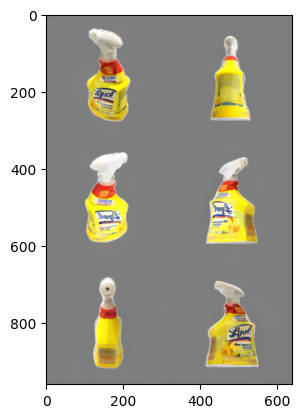

In [ ]:
import matplotlib.pyplot as plotlib
plotlib. imshow(plotlib.imread('output.png'))

In [ ]:
import torch
from PIL import Image
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

# Load the pipeline
pipeline = DiffusionPipeline.from_pretrained(
    "sudo-ai/zero123plus-v1.1",
    custom_pipeline="sudo-ai/zero123plus-pipeline",
    torch_dtype=torch.float16
)

# Update the scheduler
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config, timestep_spacing='trailing'
)

# Move the pipeline to GPU
pipeline.to('cuda:0')

# Load the local image
cond = Image.open("/content/isolated_chair.png")  # Path to your isolated chair image

# Run the pipeline
result = pipeline(cond, num_inference_steps=28).images[0]

# Display and save the result
result.show()
result.save("output.png")


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


KeyboardInterrupt: 

In [ ]:
import torch
from PIL import Image
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

# Load the pipeline
pipeline = DiffusionPipeline.from_pretrained(
    "sudo-ai/zero123plus-v1.1",
    custom_pipeline="sudo-ai/zero123plus-pipeline",
    torch_dtype=torch.float16
)

# Update the scheduler
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config, timestep_spacing='trailing'
)

# Move the pipeline to GPU
pipeline.to('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the local image
cond = Image.open("/content/isolated_chair.png")  # Path to your isolated chair image

# Define rotation angles
azimuth_angle = 72  # Rotation around the Y-axis
polar_angle = 0     # No rotation around the X-axis

# Add rotation to the prompt
prompt = f"Change pose of the object by azimuth {azimuth_angle} degrees; polar {polar_angle} degrees."

# Run the pipeline with the prompt
result = pipeline(cond, prompt=prompt, num_inference_steps=28).images[0]

# Display and save the result
result.show()
result.save("/content/output.png")  # Save the rotated image


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sudo-ai--zero123plus-v1.1/snapshots/36df7de980afd15f80b2e1a4e9a920d7020e2654/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `c

KeyboardInterrupt: 

In [ ]:
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-21-4eb9ffcd1e95> in <cell line: 16>()
     14
     15 # Resize the rotated chair to the specified width and height
---> 16 rotated_chair_resized = rotated_chair.resize((width, height), Image.ANTIALIAS)
     17
     18 # Create a blank image for the output

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)
Region of Interest (ROI) extracted.
Region of Interest saved as 'roi_chair.png'.
ROI saved at: /content/roi_chair.png
Coordinates of the detected object: (95, 118)


In [ ]:
import torch
from PIL import Image
from diffusers import DiffusionPipeline

# Load the inpainting pipeline
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
pipeline.to("cuda")  # Use GPU for faster inference

# Load the original image and the rotated isolated object image
original_image_path = "/content/chair.jpg"  # Path to your original image
rotated_object_path = "/content/output.png"  # Path to your rotated isolated object

original_image = Image.open(original_image_path).convert("RGBA")
rotated_object = Image.open(rotated_object_path).convert("RGBA")

# Specify the position to paste the rotated object (x, y)
position = coordinates  # Replace x, y with the coordinates where you want to place the object

# Create a mask for the rotated object
mask = Image.new("L", original_image.size, 0)  # Create a black mask
mask.paste(255, (position[0], position[1], position[0] + rotated_object.width, position[1] + rotated_object.height))

# Paste the rotated object onto the original image
composite_image = Image.alpha_composite(original_image, rotated_object)

# Run the inpainting model to fill in the background
result = pipeline(prompt="Fill in the background", image=composite_image, mask_image=mask, num_inference_steps=30)

# Save and show the result
result.images[0].save("/content/inpainted_image.png")
result.images[0].show()


ModuleNotFoundError: No module named 'diffusers'

In [ ]:
import torch
from PIL import Image, ImageDraw
from diffusers import DiffusionPipeline

# Step 1: Overlay Function to place rotated chair on original background
def overlay_chair(original_image, rotated_chair, position, target_size):
    # Resize rotated chair to fill the target size
    rotated_chair = rotated_chair.resize(target_size, Image.LANCZOS)  # Use LANCZOS for high-quality scaling

    # Create a new image to hold the blended result
    blended_image = Image.new("RGB", original_image.size)

    # Paste the original image onto the blended image
    blended_image.paste(original_image, (0, 0))

    # Paste the resized rotated chair image onto the blended image at the specified position
    blended_image.paste(rotated_chair, position)

    return blended_image

# Step 2: Load original image (background)
original_image_path = "/content/chair.jpg"
original_image = Image.open(original_image_path).convert("RGB")

# Step 3: Load the cropped chair image
cropped_chair_path = "/content/cropped_chair_0-removebg-preview.png"
cropped_chair = Image.open(cropped_chair_path).convert("RGBA")

# Step 4: Coordinates and dimensions for the overlay
x1, y1, x2, y2, height, width= coordinates
target_size = (width, height)  # Define target size based on coordinates

# Step 5: Create a mask for the inpainting area
mask = Image.new("L", original_image.size, 0)  # A black mask (0 means no inpainting)
mask_draw = ImageDraw.Draw(mask)
mask_draw.rectangle([x1, y1, x2, y2], fill=255)  # White mask for inpainting area

# Step 6: Use Stable Diffusion inpainting to blend the background
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16)
pipeline.to('cuda' if torch.cuda.is_available() else 'cpu')
# Define rotation angles
azimuth_angle = 72  # Rotation around the Y-axis
polar_angle = 0     # No rotation around the X-axis

# Define the prompt for blending
prompt = f"Change pose of the chair by rotating azimuth {azimuth_angle} degrees; polar {polar_angle} degrees. Seamless blending with high-quality rendering. Consistent lighting with surrounding angles."

# Run the inpainting process
result = pipeline(
    prompt=prompt,
    image=original_image,
    mask_image=mask,
    num_inference_steps=50,
    guidance_scale=7.5
).images[0]

# Step 7: Overlay the resized cropped chair onto the inpainted background
position = (x1, y1)
final_result_image = overlay_chair(result, cropped_chair, position, target_size)

# Step 8: Save and display the final result
final_result_image.save("final_result_image.png")
final_result_image.show()
